# Import de fonctions

In [ ]:
import sys
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import v_measure_score
!pip install shap
import datetime

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


# import UCSL github : Unsupervised Clustering driven by Supervised Learning 
!git clone -b sklearn_update https://github.com/rlouiset/py_ucsl > /dev/null 2>&1

sys.path.append('./py_ucsl/')
from ucsl.ucsl_classifier import *
from ucsl.ucsl_regressor import *
import cv2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.0 MB/s 


In [ ]:
# Fonction pour afficher les données matricielles sous forme d'images
def display_image(X, y, n, title, label=False):
    dim = 14
    fig, axs = plt.subplots(n, n, figsize=(5,5))

    for i in range(n):
      for j in range(n):
        axs[i,j].imshow(X[j*n+i].reshape((dim,dim)), cmap='gray')
        axs[i,j].axis('off')
    plt.title(title)
    plt.show()

# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

# Compute the coordinates of the image on the plot
def compute_plot_coordinates(image, x, y, image_centers_area_size, offset=8):
    image_height, image_width, _ = image.shape
    # compute the image center coordinates on the plot
    center_x = int(image_centers_area_size * x) + offset
    # in matplotlib, the y axis is directed upward
    # to have the same here, we need to mirror the y coordinate
    center_y = int(image_centers_area_size * (1 - y)) + offset
    # knowing the image center,
    # compute the coordinates of the top left and bottom right corner
    tl_x = center_x - int(image_width / 2)
    tl_y = center_y - int(image_height / 2)
    br_x = tl_x + image_width
    br_y = tl_y + image_height
    return tl_x, tl_y, br_x, br_y
  
colors_per_cluster = {
                      -1:np.array([0.4,0.4,0.4]),
                      0:np.array([0.9,0.05,0.05]),
                      1:np.array([0.15,0.15,0.85])
                      }

def draw_rectangle_by_conditional_pred(image, label_pred_conditionnaly_to_cluster, plot_neg=True, false_pred=False) :
  image = np.stack((image,)*3, axis=-1)

  if false_pred :
    color = np.array([0.05,1,0.05])
  elif plot_neg :
    color = colors_per_cluster[0]*label_pred_conditionnaly_to_cluster[0] + colors_per_cluster[-1]*(1-label_pred_conditionnaly_to_cluster[0])
    color += colors_per_cluster[1]*label_pred_conditionnaly_to_cluster[1] + colors_per_cluster[-1]*(1-label_pred_conditionnaly_to_cluster[1])
    color = color / 2
  else :
    color = colors_per_cluster[0]*label_pred_conditionnaly_to_cluster[0]
    color += colors_per_cluster[1]*label_pred_conditionnaly_to_cluster[1]
  image[0,:,:] = color
  image[:,-1,:] = color
  image[-1,:,:] = color
  image[:,0,:] = color
  return image

# MNIST loading

11501568/11490434 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for 

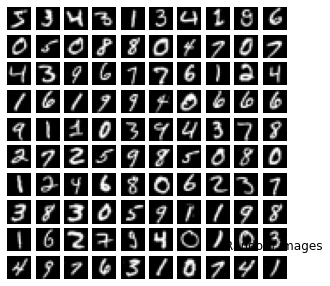

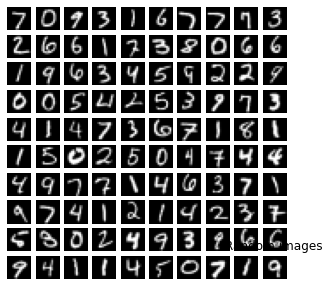

In [ ]:
# Dataset des chiffres du MNIST
from keras.datasets import mnist
from skimage.transform import resize

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = np.array([resize(img, (14,14), anti_aliasing=True) for img in X_train])
X_test= np.array([resize(img, (14,14), anti_aliasing=True) for img in X_test])
X_train = X_train[:20000]
y_train = y_train[:20000]

# flatten the images
n_samples_train = len(X_train)
X_train = X_train.reshape((n_samples_train, -1))
X_train = X_train - np.min(X_train, 1)[:, None]
X_train = X_train / np.max(X_train, 1)[:, None]

n_samples_test = len(X_test)
X_test = X_test.reshape((n_samples_test, -1))
X_test = X_test - np.min(X_test, 1)[:, None]
X_test = X_test / np.max(X_test, 1)[:, None]

X_train = np.array(X_train).astype(np.float)
X_test = np.array(X_test).astype(np.float)
y_train = np.array(y_train).astype(np.float)
y_test = np.array(y_test).astype(np.float)

display_image(X_train, y_train, n=10, title='Random images',)
display_image(X_test, y_test, n=10, title='Random images',)

# Unsupervised clustering subtypes of digit 7

In [ ]:
# load ground truth label
import json

label_mapping_seven = {'No bar':0, 'With bar':1}
with open("/content/drive/MyDrive/Neurospin/Thèse Robin/UCSL/mnist_labels.json") as json_file:
    ground_truth_dict = json.load(json_file)
    y_ground_truth = np.array([label_mapping_seven[ground_truth_dict[key]] for key in ground_truth_dict.keys()])

In [ ]:
pos_label = 7
print("The label to cluster is : ", pos_label)

positive_labels_indices = np.array([i for (i, y_i) in enumerate(y_train) if y_i in [7]])
test_positive_labels_indices = np.array([i for (i, y_i) in enumerate(y_test) if y_i in [7]])
X_train_pos = X_train[positive_labels_indices]
X_test_pos = X_test[test_positive_labels_indices]


The label to cluster is :  7


# TSNE + clustering

In [ ]:
# KMeans training
b_acc_results = []
ari_results = []
v_measure_results = []
begin_time = datetime.datetime.now()
for i in range(0, 5) :
  
  KMeans_tsne = TSNE(n_components=2)
  X_test_tsne = KMeans_tsne.fit_transform(X_test)
  KMeans_method = GaussianMixture(n_components=2, covariance_type="full")
  y_pred = KMeans_method.fit_predict(X_test_tsne[test_positive_labels_indices])
  print("Cluster 0 number of samples : ", np.sum(y_pred==0))
  print("Cluster 1 number of samples : ", np.sum(y_pred==1))

  print("KM balanced accuracy score with hand-crafted labels : ", balanced_accuracy_score(y_ground_truth, y_pred[:len(y_ground_truth)]))
  print("KM ari with hand-crafted labels : ", ARI(y_ground_truth, y_pred[:len(y_ground_truth)]))
  print("KM vm with hand-crafted labels : ", v_measure_score(y_ground_truth, y_pred[:len(y_ground_truth)]))
  
  b_acc_results.append(max(balanced_accuracy_score(y_ground_truth, y_pred[:len(y_ground_truth)]), balanced_accuracy_score(1-y_ground_truth, y_pred[:len(y_ground_truth)])))
  ari_results.append(ARI(y_ground_truth, y_pred[:len(y_ground_truth)]))
  v_measure_results.append(v_measure_score(y_ground_truth, y_pred[:len(y_ground_truth)]))


print('---------------------')
print(datetime.datetime.now() - begin_time)
print("B-acc : ", str(np.mean(b_acc_results)) + "+/-" + str(np.std(b_acc_results)))
print("ARI : ", str(np.mean(ari_results)) + "+/-" + str(np.std(ari_results)))
print("V-measure : ", str(np.mean(v_measure_results)) + "+/-" + str(np.std(v_measure_results)))


Cluster 0 number of samples :  939
Cluster 1 number of samples :  89
KM balanced accuracy score with hand-crafted labels :  0.5788608418673151
KM ari with hand-crafted labels :  0.11869523644945407
KM vm with hand-crafted labels :  0.038798406173425275
Cluster 0 number of samples :  471
Cluster 1 number of samples :  557
KM balanced accuracy score with hand-crafted labels :  0.6237455903003734
KM ari with hand-crafted labels :  0.04570099376935967
KM vm with hand-crafted labels :  0.03667218983159308
Cluster 0 number of samples :  498
Cluster 1 number of samples :  530
KM balanced accuracy score with hand-crafted labels :  0.4368599513648662
KM ari with hand-crafted labels :  -0.01343085939283358
KM vm with hand-crafted labels :  0.01029389089755494
Cluster 0 number of samples :  497
Cluster 1 number of samples :  531
KM balanced accuracy score with hand-crafted labels :  0.5197794293934308
KM ari with hand-crafted labels :  -0.010739786898905701
KM vm with hand-crafted labels :  0.001

In [ ]:
# GMM training
b_acc_results = []
ari_results = []
v_measure_results = []
begin_time = datetime.datetime.now()

for i in range(0, 5) :
  KMeans_tsne = TSNE(n_components=2)
  X_test_tsne = KMeans_tsne.fit_transform(X_test)
  GMM_method = GaussianMixture(n_components=2, covariance_type="full")
  y_pred = GMM_method.fit_predict(X_test_tsne[test_positive_labels_indices])
  print("Cluster 0 number of samples : ", np.sum(y_pred==0))
  print("Cluster 1 number of samples : ", np.sum(y_pred==1))

  print("GMM balanced accuracy score with hand-crafted labels : ", balanced_accuracy_score(y_ground_truth, y_pred[:len(y_ground_truth)]))
  print("GMM ari with hand-crafted labels : ", ARI(y_ground_truth, y_pred[:len(y_ground_truth)]))
  print("GMM vm with hand-crafted labels : ", v_measure_score(y_ground_truth, y_pred[:len(y_ground_truth)]))
  
  b_acc_results.append(max(balanced_accuracy_score(y_ground_truth, y_pred[:len(y_ground_truth)]), balanced_accuracy_score(1-y_ground_truth, y_pred[:len(y_ground_truth)])))
  ari_results.append(ARI(y_ground_truth, y_pred[:len(y_ground_truth)]))
  v_measure_results.append(v_measure_score(y_ground_truth, y_pred[:len(y_ground_truth)]))

print('---------------------')
print(datetime.datetime.now() - begin_time)
print("B-acc : ", str(np.mean(b_acc_results)) + "+/-" + str(np.std(b_acc_results)))
print("ARI : ", str(np.mean(ari_results)) + "+/-" + str(np.std(ari_results)))
print("V-measure : ", str(np.mean(v_measure_results)) + "+/-" + str(np.std(v_measure_results)))

Cluster 0 number of samples :  628
Cluster 1 number of samples :  400
GMM balanced accuracy score with hand-crafted labels :  0.3752269068739939
GMM ari with hand-crafted labels :  0.02352347255859574
GMM vm with hand-crafted labels :  0.037929788681808
Cluster 0 number of samples :  991
Cluster 1 number of samples :  37
GMM balanced accuracy score with hand-crafted labels :  0.560537041476864
GMM ari with hand-crafted labels :  0.11330776553618588
GMM vm with hand-crafted labels :  0.05892239684327676
Cluster 0 number of samples :  483
Cluster 1 number of samples :  545
GMM balanced accuracy score with hand-crafted labels :  0.4320478131314861
GMM ari with hand-crafted labels :  -0.009924068896476365
GMM vm with hand-crafted labels :  0.011670281682516867
Cluster 0 number of samples :  543
Cluster 1 number of samples :  485
GMM balanced accuracy score with hand-crafted labels :  0.4802205706065692
GMM ari with hand-crafted labels :  -0.010739786898905701
GMM vm with hand-crafted label

# UMAP + clustering

In [ ]:
!pip install umap-learn
import umap

# KMeans + umap training
b_acc_results = []
ari_results = []
v_measure_results = []
begin_time = datetime.datetime.now()
for i in range(0, 5) :
  KMeans_umap = umap.UMAP(n_components=2)
  X_test_umap = KMeans_umap.fit_transform(X_test)
  KMeans_method = KMeans(n_clusters=2)
  y_pred = KMeans_method.fit_predict(X_test_umap[test_positive_labels_indices])
  print("Cluster 0 number of samples : ", np.sum(y_pred==0))
  print("Cluster 1 number of samples : ", np.sum(y_pred==1))

  print("KM balanced accuracy score with hand-crafted labels : ", balanced_accuracy_score(y_ground_truth, y_pred[:len(y_ground_truth)]))
  print("KM ari with hand-crafted labels : ", ARI(y_ground_truth, y_pred[:len(y_ground_truth)]))
  print("KM vm with hand-crafted labels : ", v_measure_score(y_ground_truth, y_pred[:len(y_ground_truth)]))
  
  b_acc_results.append(max(balanced_accuracy_score(y_ground_truth, y_pred[:len(y_ground_truth)]), balanced_accuracy_score(1-y_ground_truth, y_pred[:len(y_ground_truth)])))
  ari_results.append(ARI(y_ground_truth, y_pred[:len(y_ground_truth)]))
  v_measure_results.append(v_measure_score(y_ground_truth, y_pred[:len(y_ground_truth)]))

print('---------------------')
print(datetime.datetime.now() - begin_time)
print("B-acc : ", str(np.mean(b_acc_results)) + "+/-" + str(np.std(b_acc_results)))
print("ARI : ", str(np.mean(ari_results)) + "+/-" + str(np.std(ari_results)))
print("V-measure : ", str(np.mean(v_measure_results)) + "+/-" + str(np.std(v_measure_results)))

     |████████████████████████████████| 81kB 3.8MB/s 
     |████████████████████████████████| 1.2MB 9.5MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=2f63772ec06199c40421d64a319684c36a7d187bd513cb888c2a6aca90eca924
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=d61f8e53ebaabdd0a84a338cae2fc996a022480fec92197fdaadad2ea7ec2478
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent
Cluster 0 number of samples :  1002
Cluster 1 number of samples :  26
KM balanced accuracy score with hand-crafted labels :  0.5397472343048944
KM ari with hand-crafted labels :  0.07706294510492873
KM vm with hand-crafted labels :  0.04342302539011947
Cluster 0 number of samples :  1004
Cluster 1 number of sample

# KMeans / GMM

In [ ]:
# KMeans training
b_acc_results = []
ari_results = []
v_measure_results = []
begin_time = datetime.datetime.now()

for i in range(0, 5) :
  KMeans_method = KMeans(n_clusters=2)
  KMeans_method.fit(X_train[positive_labels_indices])
  y_pred = KMeans_method.predict(X_test[test_positive_labels_indices])
  print("Cluster 0 number of samples : ", np.sum(y_pred==0))
  print("Cluster 1 number of samples : ", np.sum(y_pred==1))

  print("KM balanced accuracy score with hand-crafted labels : ", balanced_accuracy_score(y_ground_truth, y_pred[:len(y_ground_truth)]))
  print("KM ari with hand-crafted labels : ", ARI(y_ground_truth, y_pred[:len(y_ground_truth)]))
  print("KM vm with hand-crafted labels : ", v_measure_score(y_ground_truth, y_pred[:len(y_ground_truth)]))
  
  b_acc_results.append(max(balanced_accuracy_score(y_ground_truth, y_pred[:len(y_ground_truth)]), balanced_accuracy_score(1-y_ground_truth, y_pred[:len(y_ground_truth)])))
  ari_results.append(ARI(y_ground_truth, y_pred[:len(y_ground_truth)]))
  v_measure_results.append(v_measure_score(y_ground_truth, y_pred[:len(y_ground_truth)]))

print('---------------------')
print(datetime.datetime.now() - begin_time)
print("B-acc : ", str(np.mean(b_acc_results)) + "+/-" + str(np.std(b_acc_results)))
print("ARI : ", str(np.mean(ari_results)) + "+/-" + str(np.std(ari_results)))
print("V-measure : ", str(np.mean(v_measure_results)) + "+/-" + str(np.std(v_measure_results)))

Cluster 0 number of samples :  517
Cluster 1 number of samples :  511
KM balanced accuracy score with hand-crafted labels :  0.44790560674041857
KM ari with hand-crafted labels :  0.010824942871737063
KM vm with hand-crafted labels :  0.006458198029272191
Cluster 0 number of samples :  511
Cluster 1 number of samples :  517
KM balanced accuracy score with hand-crafted labels :  0.5520943932595814
KM ari with hand-crafted labels :  0.010824942871737063
KM vm with hand-crafted labels :  0.006458198029272191
Cluster 0 number of samples :  517
Cluster 1 number of samples :  511
KM balanced accuracy score with hand-crafted labels :  0.44790560674041857
KM ari with hand-crafted labels :  0.010824942871737063
KM vm with hand-crafted labels :  0.006458198029272191
Cluster 0 number of samples :  511
Cluster 1 number of samples :  517
KM balanced accuracy score with hand-crafted labels :  0.5520943932595814
KM ari with hand-crafted labels :  0.010824942871737063
KM vm with hand-crafted labels : 

In [ ]:
# GMM training
b_acc_results = []
ari_results = []
v_measure_results = []
begin_time = datetime.datetime.now()

for i in range(0, 5) :
  GMM_method = GaussianMixture(n_components=2, covariance_type="full")
  y_pred = GMM_method.fit_predict(X_test[test_positive_labels_indices])
  print("Cluster 0 number of samples : ", np.sum(y_pred==0))
  print("Cluster 1 number of samples : ", np.sum(y_pred==1))

  print("GMM balanced accuracy score with hand-crafted labels : ", balanced_accuracy_score(y_ground_truth, y_pred[:len(y_ground_truth)]))
  print("GMM ari with hand-crafted labels : ", ARI(y_ground_truth, y_pred[:len(y_ground_truth)]))
  print("GMM vm with hand-crafted labels : ", v_measure_score(y_ground_truth, y_pred[:len(y_ground_truth)]))
  
  b_acc_results.append(max(balanced_accuracy_score(y_ground_truth, y_pred[:len(y_ground_truth)]), balanced_accuracy_score(1-y_ground_truth, y_pred[:len(y_ground_truth)])))
  ari_results.append(ARI(y_ground_truth, y_pred[:len(y_ground_truth)]))
  v_measure_results.append(v_measure_score(y_ground_truth, y_pred[:len(y_ground_truth)]))

print('---------------------')
print(datetime.datetime.now() - begin_time)
print("B-acc : ", str(np.mean(b_acc_results)) + "+/-" + str(np.std(b_acc_results)))
print("ARI : ", str(np.mean(ari_results)) + "+/-" + str(np.std(ari_results)))
print("V-measure : ", str(np.mean(v_measure_results)) + "+/-" + str(np.std(v_measure_results)))

Cluster 0 number of samples :  575
Cluster 1 number of samples :  453
GMM balanced accuracy score with hand-crafted labels :  0.4896050964140151
GMM ari with hand-crafted labels :  -0.0019410811224733016
GMM vm with hand-crafted labels :  0.0002554929379612723
Cluster 0 number of samples :  575
Cluster 1 number of samples :  453
GMM balanced accuracy score with hand-crafted labels :  0.4896050964140151
GMM ari with hand-crafted labels :  -0.0019410811224733016
GMM vm with hand-crafted labels :  0.0002554929379612723
Cluster 0 number of samples :  575
Cluster 1 number of samples :  453
GMM balanced accuracy score with hand-crafted labels :  0.4896050964140151
GMM ari with hand-crafted labels :  -0.0019410811224733016
GMM vm with hand-crafted labels :  0.0002554929379612723
Cluster 0 number of samples :  575
Cluster 1 number of samples :  453
GMM balanced accuracy score with hand-crafted labels :  0.4896050964140151
GMM ari with hand-crafted labels :  -0.0019410811224733016
GMM vm with h

# SHAP + clustering

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import shap

# GMM training
begin_time = datetime.datetime.now()
classifier = RandomForestClassifier()
y_train_shap = np.array([0]*len(y_train))
y_train_shap[test_positive_labels_indices] = 1
classifier.fit(X_train, y_train_shap)
shap_values = shap.TreeExplainer(classifier).shap_values(X_test)
shap_values = np.array(shap_values) 

GMM_method = KMeans(n_clusters=2)
y_pred = GMM_method.fit_predict(shap_values[1][test_positive_labels_indices])
print("Cluster 0 number of samples : ", np.sum(y_pred==0))
print("Cluster 1 number of samples : ", np.sum(y_pred==1))

print("GMM balanced accuracy score with hand-crafted labels : ", balanced_accuracy_score(y_ground_truth, y_pred[:len(y_ground_truth)]))
print("GMM ari with hand-crafted labels : ", ARI(y_ground_truth, y_pred[:len(y_ground_truth)]))
print("GMM vm with hand-crafted labels : ", v_measure_score(y_ground_truth, y_pred[:len(y_ground_truth)]))

print(datetime.datetime.now() - begin_time)
    


Cluster 0 number of samples :  515
Cluster 1 number of samples :  513
GMM balanced accuracy score with hand-crafted labels :  0.43129431105935545
GMM ari with hand-crafted labels :  0.022682968265464006
GMM vm with hand-crafted labels :  0.011363076679922573
1:07:40.405239


# UCSL

In [ ]:
# UCSL training
training_label_mapping={0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:1, 8:0, 9:0}
n_clusters_per_label={0:1, 1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:2, 8:1, 9:1}

for i in range(0, 5) :
    # UCSL training
    UCSL_method = UCSL_C(n_clusters=2, training_label_mapping=training_label_mapping, label_to_cluster=1, n_iterations=20,
                        clustering="full_gaussian_mixture", maximization="linear")
    UCSL_method = UCSL_method.fit(X_train, y_train)

    # UCSL predictions
    y_ones, y_pred = UCSL_method.predict(X_test_pos, np.ones(len(X_test_pos)))

    print("Cluster 0 number of samples : ", np.sum(y_pred==0))
    print("Cluster 1 number of samples : ", np.sum(y_pred==1))

    print("UCSL balanced accuracy score with hand-crafted labels : ", max(balanced_accuracy_score(y_ground_truth, y_pred[:len(y_ground_truth)]), balanced_accuracy_score(y_ground_truth, 1-y_pred[:len(y_ground_truth)])))
    print("UCSL ari with hand-crafted labels : ", ARI(y_ground_truth, y_pred[:len(y_ground_truth)]))
    print("UCSL vm with hand-crafted labels : ", v_measure_score(y_ground_truth, y_pred[:len(y_ground_truth)]))

    print("-----------------------------------------")

Cluster 0 number of samples :  792
Cluster 1 number of samples :  236
UCSL balanced accuracy score with hand-crafted labels :  0.8043977120937083
UCSL ari with hand-crafted labels :  0.33159263187698995
UCSL vm with hand-crafted labels :  0.24467366602283538
-----------------------------------------
Cluster 0 number of samples :  764
Cluster 1 number of samples :  264
UCSL balanced accuracy score with hand-crafted labels :  0.8067438435455698
UCSL ari with hand-crafted labels :  0.2972011161042546
UCSL vm with hand-crafted labels :  0.2448231379594274
-----------------------------------------
Cluster 0 number of samples :  780
Cluster 1 number of samples :  248
UCSL balanced accuracy score with hand-crafted labels :  0.7925985546460252
UCSL ari with hand-crafted labels :  0.3035332988003063
UCSL vm with hand-crafted labels :  0.22361080159816749
-----------------------------------------
Cluster 0 number of samples :  789
Cluster 1 number of samples :  239
UCSL balanced accuracy score w

# HYDRA

In [ ]:
# UCSL training
training_label_mapping={0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8, 9:9}
n_clusters_per_label={0:1, 1:1, 2:1, 3:1, 4:1, 5:1, 6:1, 7:2, 8:1, 9:1}

begin_time = datetime.datetime.now()
b_acc_results = []
ari_results = []
v_measure_results = []

for i in range(0, 5) :
  UCSL_method = UCSL_C(multiclass_config='ovr', n_labels=10, n_iterations=20, 
                      training_label_mapping=training_label_mapping, n_clusters_per_label=n_clusters_per_label,
                      negative_weighting="all", maximization="max_margin", clustering="HYDRA")
  UCSL_method = UCSL_method.fit(X_train, y_train)
  print(datetime.datetime.now() - begin_time)

  # UCSL predictions
  y_pred = np.argmax(UCSL_method.predict_clusters(X_test_pos)[pos_label], 1)
  print("Cluster 0 number of samples : ", np.sum(y_pred==0))
  print("Cluster 1 number of samples : ", np.sum(y_pred==1))

  print("UCSL balanced accuracy score with hand-crafted labels : ", balanced_accuracy_score(y_ground_truth, y_pred[:len(y_ground_truth)]))
  print("UCSL ari with hand-crafted labels : ", ARI(y_ground_truth, y_pred[:len(y_ground_truth)]))
  print("UCSL vm with hand-crafted labels : ", v_measure_score(y_ground_truth, y_pred[:len(y_ground_truth)]))

  b_acc_results.append(max(balanced_accuracy_score(y_ground_truth, y_pred[:len(y_ground_truth)]), balanced_accuracy_score(1-y_ground_truth, y_pred[:len(y_ground_truth)])))
  ari_results.append(ARI(y_ground_truth, y_pred[:len(y_ground_truth)]))
  v_measure_results.append(v_measure_score(y_ground_truth, y_pred[:len(y_ground_truth)]))

print('---------------------')
print(datetime.datetime.now() - begin_time)
print("B-acc : ", str(np.mean(b_acc_results)) + "+/-" + str(np.std(b_acc_results)))
print("ARI : ", str(np.mean(ari_results)) + "+/-" + str(np.std(ari_results)))
print("V-measure : ", str(np.mean(v_measure_results)) + "+/-" + str(np.std(v_measure_results)))

0:10:04.845774
Cluster 0 number of samples :  926
Cluster 1 number of samples :  102
UCSL balanced accuracy score with hand-crafted labels :  0.5020550056512656
UCSL ari with hand-crafted labels :  0.0018614625109770952
UCSL vm with hand-crafted labels :  3.163337229079486e-05
0:19:27.350639
Cluster 0 number of samples :  950
Cluster 1 number of samples :  78
UCSL balanced accuracy score with hand-crafted labels :  0.5339589683871631
UCSL ari with hand-crafted labels :  0.05291561443044908
UCSL vm with hand-crafted labels :  0.010678496061381049
0:28:58.577203
Cluster 0 number of samples :  111
Cluster 1 number of samples :  917
UCSL balanced accuracy score with hand-crafted labels :  0.45006336267424735
UCSL ari with hand-crafted labels :  0.07050528555997546
UCSL vm with hand-crafted labels :  0.01575729941691307
0:38:06.489635
Cluster 0 number of samples :  143
Cluster 1 number of samples :  885
UCSL balanced accuracy score with hand-crafted labels :  0.509230400383601
UCSL ari with

# Visualizations

179


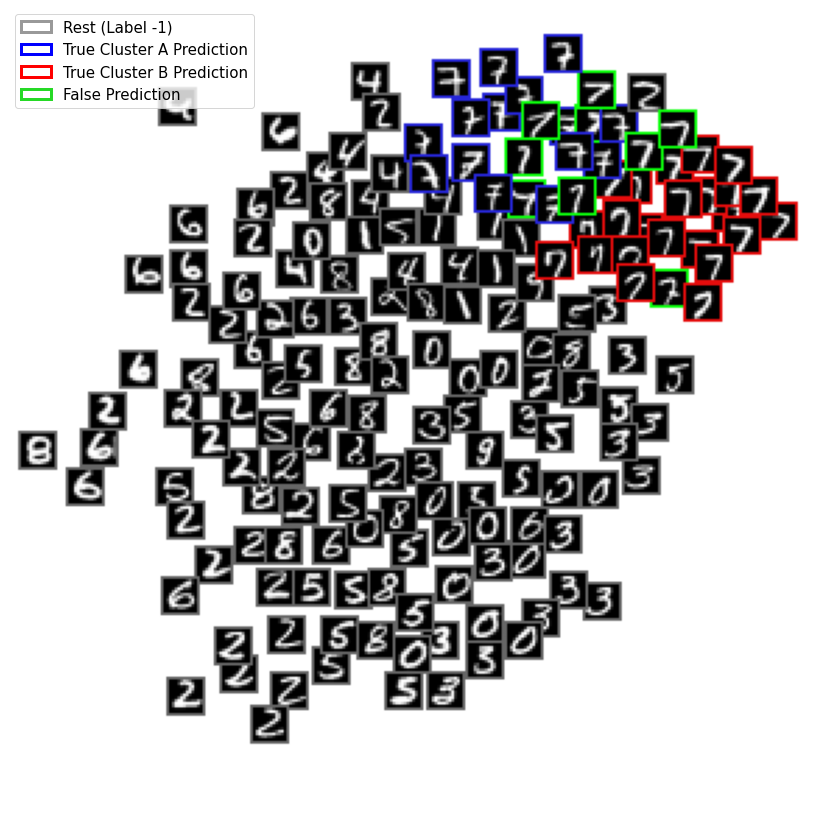

In [ ]:
# go to latent space
X_test_latent = X_test @ UCSL_method.orthonormal_basis[7][-1].T
gmm_estimator = UCSL_method.clustering_method[7][-1]
covars = gmm_estimator.covariances_.copy()
means = gmm_estimator.means_.copy()

# coefficietn and intercept
coefficients = UCSL_method.coefficients[7].copy()
intercepts = UCSL_method.intercepts[7].copy()
y_pred = np.argmax(UCSL_method.predict_clusters(X_test)[pos_label], 1)
label_pred_conditionnaly_to_cluster = [{c:sigmoid(X_test@coefficients[c][0]+intercepts[c][0])[i] for c in [0,1]} for i in range(len(X_test))]

img_dim = 14
offset = img_dim // 2 + 1
huge_image_size = 275

# print mnist latent space
tsne = X_test_latent.copy()

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

# init the plot as white canvas
tsne_plot = np.ones((huge_image_size+2*offset+1, huge_image_size+2*offset+1, 3))

c=0
t=0
# now we'll put a small copy of every image to its corresponding T-SNE coordinate
for image, label, pred, x, y in zip(X_test, y_test, 1-y_pred, tx, ty) :
    if label != 7 :
      if np.random.uniform(0,1) < 0.8 :
        continue
    elif c >= len(y_ground_truth) :
      continue
    else :
      cluster=y_ground_truth[c]
      c+=1
    image = np.reshape(image, (img_dim,img_dim))
    if label==7 and pred==cluster :
      image = draw_rectangle_by_conditional_pred(image, {0:(1-cluster), 1:cluster}, plot_neg=False)
    if label==7 and pred!=cluster :
      if np.random.uniform(0,1) < 0.2 :
        continue
      image = draw_rectangle_by_conditional_pred(image, {0:0.5, 1:0.5}, false_pred=True)
    if label!=7 :
      image = draw_rectangle_by_conditional_pred(image, {0:0, 1:0})
    # compute the coordinates of the image on the scaled plot visualization
    tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, huge_image_size)
    # put the image to its t-SNE coordinates using numpy sub-array indices
    if label != 7 :
      if np.sum(tsne_plot[tl_y:br_y, tl_x:br_x])/3 > (img_dim**2-(offset-2)**2) :
        tsne_plot[tl_y:br_y, tl_x:br_x, :] = image
        t=t+1
    else :
      if np.sum(tsne_plot[tl_y:br_y, tl_x:br_x])/3 > (img_dim**2-(offset+1)**2) :
        tsne_plot[tl_y:br_y, tl_x:br_x, :] = image
        t=t+1


fig = plt.figure(figsize=(15, 15))
# plot gaussian mixture covariance
colors = ['r', 'b']
for factor in [8] :
  for c_idx in [0, 1] :
    covar=covars[c_idx]
    mean=means[c_idx]-(3*offset/huge_image_size)
    v, w = linalg.eigh(covar/factor)
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    u = w[0] / linalg.norm(w[0])

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan(u[1] / u[0])
    angle = 180. * angle / np.pi  # convert to degrees
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle,  fc=colors[c_idx])
    ell.set_clip_box(fig.bbox)
    ell.set_alpha(0.4)
    #fig.add_artist(ell)

legend_elements = [Patch(label='Rest (Label -1)', fill=False, edgecolor='#999999', linewidth=3),
                   Patch(label='True Cluster A Prediction', fill=False, edgecolor='b', linewidth=3),
                   Patch(label='True Cluster B Prediction', fill=False, edgecolor='r', linewidth=3),
                   Patch(label='False Prediction', fill=False, edgecolor=[0.15,0.85,0.15], linewidth=3),]

plt.axis('off')
plt.legend(handles=legend_elements, loc='upper left', prop={'size': 15})
plt.imshow(tsne_plot)
print(t)

Cluster 0 number of samples :  509
Cluster 1 number of samples :  519


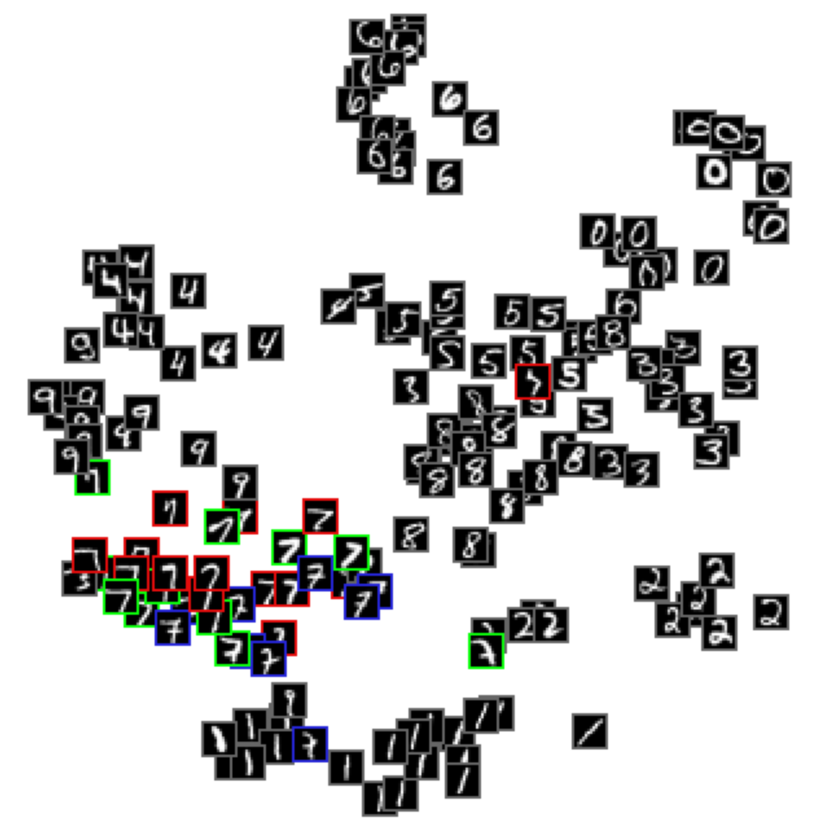

In [ ]:
# go to K-Means t-SNE space
KMeans_tsne = TSNE(n_components=2)
X_test_tsne = KMeans_tsne.fit_transform(X_test)
tsne = X_test_tsne.copy()
KMeans_method = KMeans(n_clusters=2)
y_pred = KMeans_method.fit_predict(X_test_tsne[test_positive_labels_indices])
print("Cluster 0 number of samples : ", np.sum(y_pred==0))
print("Cluster 1 number of samples : ", np.sum(y_pred==1))

# define plot hyperparameters
img_dim = 14
offset = img_dim // 2
huge_image_size = 300

# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

# init the plot as white canvas
fig = plt.figure(figsize=(15, 15))
tsne_plot = np.ones((huge_image_size+2*offset+1, huge_image_size+2*offset+1, 3))

c=0
t = 0
# now we'll put a small copy of every image to its corresponding T-SNE coordinate
for image, label, pred, x, y in zip(X_test, y_test, y_pred, tx, ty) :
    if label != 7 :
      if np.random.uniform(0,1) < 0.8 :
        continue
    elif c >= len(y_ground_truth) :
      continue
    else :
      cluster=y_ground_truth[c]
      c+=1
    image = np.reshape(image, (img_dim,img_dim))
    if label==7 and pred==cluster :
      image = draw_rectangle_by_conditional_pred(image, {0:(1-cluster), 1:cluster}, plot_neg=False)
    if label==7 and pred!=cluster :
      if np.random.uniform(0,1) < 0.5 :
        continue
      image = draw_rectangle_by_conditional_pred(image, {0:0.5, 1:0.5}, false_pred=True)
    if label!=7 :
      image = draw_rectangle_by_conditional_pred(image, {0:0, 1:0})
    # compute the coordinates of the image on the scaled plot visualization
    tl_x, tl_y, br_x, br_y = compute_plot_coordinates(image, x, y, huge_image_size)
    # put the image to its t-SNE coordinates using numpy sub-array indices
    if label != 7 :
      if np.sum(tsne_plot[tl_y:br_y, tl_x:br_x])/3 > (img_dim**2-(offset+4)**2) :
        t=t+1
        tsne_plot[tl_y:br_y, tl_x:br_x, :] = image
    else :
      if np.sum(tsne_plot[tl_y:br_y, tl_x:br_x])/3 > (img_dim**2-(offset+3)**2) :
        t=t+1
        tsne_plot[tl_y:br_y, tl_x:br_x, :] = image


legend_elements = [Patch(label='Rest (Label -1)', fill=False, edgecolor='#999999', linewidth=2),
                   Patch(label='True Cluster A Prediction', fill=False, edgecolor='b', linewidth=2),
                   Patch(label='True Cluster B Prediction', fill=False, edgecolor='r', linewidth=2),
                   Patch(label='False Prediction', fill=False, edgecolor=[0.15,0.85,0.15], linewidth=2),]

plt.axis('off')
#plt.legend(handles=legend_elements, loc='upper right', prop={'size': 15})

plt.imshow(tsne_plot, cmap='gray')